In [10]:
import utils
import cv2
import imutils
import glob
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
import skimage
from sklearn.cluster import KMeans
from collections import Counter

In [9]:
train = True

In [64]:
class ImageMerger:
    """
    ImageMerger can merge images from a dataset including images collected by a drone with the purpose of detecting 
    moving people in the images.
    """
    def __init__(self, data_dir, mask_file):
        """
        :param data_dir: path to the directory where the data is located
        :param mask_file: path of a mask which removes unneccesary text from the images
        """
        
        # Get all directories inside the data_dir
        self.data_dir = data_dir
        self.dirs = os.listdir(data_dir)
        self.mask = np.array(cv2.imread(mask_file)) // 255
        
        # Store the merged images
        self.merged_images = {}
        
    def load_images(self):
        """
        Loads the images and homographies from one directory at a time and yields them
        """
        
        for a_dir in self.dirs:
            if a_dir == 'labels.json':
                continue
            input_images = {}
            
            # Load all images in the train directory
            image_dir_file_path = os.path.join(os.path.join(self.data_dir, a_dir), '*.png')
            images = glob.glob(image_dir_file_path)
            
            # Copy all the raw images to the input images dict
            for im in images:
                file = os.path.basename(im)
                img_name = os.path.splitext(file)[0]
                src = cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2RGB)
                src = self.apply_mask(src)
                input_images[img_name] = src
            
            # Load the homographies json file
            homographies_file_path = os.path.join(os.path.join(self.data_dir, a_dir), 'homographies.json')
            with open(homographies_file_path, 'rb') as f:
                homographies = json.load(f)
            
            yield a_dir, input_images, homographies
        
    def apply_mask(self, image):
        """
        Applys the provided mask on image
        :param image: image file which will be treated as np.array
        """

        return image * self.mask
    
    def merge_images(self, alpha=0.75, axis=0, method='ltr', debug=False):
        """
        Merges all the images given the homographies which are retrieved from load_data. 
        :param alpha: Weighting for merging the images. The image to be merged on will be considered with a weight a alpha,
        the second image with a weight of 1-alpha.
        :param axis: defines the axis along which the images shall be merged. 0: camera axis, 1: time axis
        :param method: defines in which order the images shall be merged:
            - ltr:  The images are merged from left to right along the camera axis or from the first in time (index 0) 
                    to the last in time (index 6)
            - rtl:  The images are merged from right to left along the camera axis or from the last in time (index 6) 
                    to the first in time (index 0)
            - outl: The images are merged from the center out switching between the left and right side of the center 
                    (along camera axis)/previous and next in time (along time axis) starting with the left side/previous 
                    in time. 
            - outr: The images are merged from the center out switching between the left and right side of the center 
                    (along camera axis)/previous and next in time (along time axis) starting with the right side/next in 
                    time.
            - inl:  The images are merged from the outside inward switching between the left and right side of the center 
                    (along camera axis)/previous and next in time (along time axis) starting with the left side/previous 
                    in time. 
            - inr:  The images are merged from the outside inward switching between the left and right side of the center 
                    (along camera axis)/previous and next in time (along time axis) starting with the right side/next in 
                    time.
        :param debug: if True, results are printed to be able to debug 
        """
        
        assert method in ['ltr', 'rtl', 'outl', 'outr', 'inl', 'inr']
        
        # Define the keys and indices depending on axis and method
        keys = []
        indices = []
        if axis == 0:
            indices = range(0, 7)
            if method == 'ltr':
                keys = ['-B05', '-B04', '-B03', '-B02', '-B01', '-G01', '-G02', '-G03', '-G04', '-G05']
            elif method == 'rtl': 
                keys = ['-G05', '-G04', '-G03', '-G02', '-G01', '-B01', '-B02', '-B03', '-B04', '-B05']
            elif method == 'outl':
                keys = ['-B01', '-G01', '-B02', '-G02', '-B03', '-G03', '-B04', '-G04', '-B05', '-G05']
            elif method == 'outr':
                keys = ['-G01', '-B01', '-G02', '-B02', '-G03', '-B03', '-G04', '-B04', '-G05', '-B05']
            elif method == 'inl':
                keys = ['-B05', '-G05', '-B04', '-G04', '-B03', '-G03', '-B02', '-G02', '-B01', '-G01']
            elif method == 'inr':
                keys = ['-G05', '-B05', '-G04', '-B04', '-G03', '-B03', '-G02', '-B02', '-G01', '-B01']
        elif axis == 1:
            indices = ['-B05', '-B04', '-B03', '-B02', '-B01', '-G01', '-G02', '-G03', '-G04', '-G05']
            if method == 'ltr':
                keys = [0, 1, 2, 3, 4, 5, 6]
            elif method == 'rtl': 
                keys = [6, 5, 4, 3, 2, 1, 0]
            elif method == 'outl':
                keys = [3, 2, 4, 1, 5, 0, 6]
            elif method == 'outr':
                keys = [3, 4, 2, 5, 1, 6, 0]
            elif method == 'inl':
                keys = [0, 6, 1, 5, 2, 4, 3]
            elif method == 'inr':
                keys = [6, 0, 5, 1, 4, 2, 3]
                
        # Do the merging by looping through all indices and keys
        for a_dir, images, homographies in self.load_images():
            # Loop through the indices
            for i in indices: 
                # Load the base image depending on the method
                base_image_key = ''
                if axis == 0:
                    base_image_key = str(i) + keys[0]
                elif axis == 1:
                    base_image_key = str(keys[0]) + i
                    
                # Define the merged image and set it to the base image as the start
                merged_image = images[base_image_key]
                
                if debug:
                    print('directory: ', a_dir)
                    print('base key: ', base_image_key)

                for k in keys:
                    # Get the key given the index and k
                    key = ''
                    if axis == 0:
                        key = str(i) + k
                    elif axis == 1:
                         key = str(k) + i
                        
                    # Load the image and the corresponding homography matrix
                    im = images[key]
                    homography = np.array(homographies[key])
                    
                    # Warp the perspective (i.e. transform the current image into the perspective of the base image (-B01))
                    im_warped = cv2.warpPerspective(im, homography, im.shape[:2])
                    # Merge the images
                    merged_image = cv2.addWeighted(merged_image, alpha, im_warped, 1 - alpha, 0.0)

                self.merged_images[a_dir + '-' + str(i)] = merged_image
                
                if debug:
                    plt.imshow(merged_image)
                    plt.show()
            break

In [79]:
image_merger = ImageMerger('../4_Notebooks/data_WiSAR/data/validation/', '../4_Notebooks/data_WiSAR/data/mask.png')
image_merger.merge_images(axis=0, method='outl', debug=False, alpha=0.75)
valid_images = image_merger.merged_images

In [78]:
image_merger = ImageMerger('../4_Notebooks/data_WiSAR/data/train/', '../4_Notebooks/data_WiSAR/data/mask.png')
image_merger.merge_images(axis=0, method='outl', debug=False, alpha=0.75)
train_images = image_merger.merged_images

In [85]:
def mahalanobis(image, threshold=4):

    array = image.copy()
    Xpix = array.shape[0]
    Ypix = array.shape[1]
    
    # offset because of black regions:
    xOffset = 110
    yOffsetDown = 300
    yOffsetUp = 1024 - 950
    
    mean_vector = np.mean(array, axis=(0, 1))
    
    reshaped_array = array.reshape((Xpix * Ypix, 3))

    number = 100000
    # sample the above array to reduce computing time
    choices = np.random.randint(0, len(reshaped_array), number)
    reshaped_array = np.array([reshaped_array[i] for i in choices])
    average = np.mean(reshaped_array)
    # compute the variance-covariance matrix for these RGB data
    matrix = np.array(sum([np.outer(np.array([reshaped_array[i] - \
       average]), np.array(reshaped_array[i] - average)) for i in \
        range(len(reshaped_array))]) / len(reshaped_array))

    variance_covariance = np.linalg.inv(matrix)

    # iterate over the original image and store dM in this new array
    distances = np.zeros([Xpix, Ypix])
    for i in range(yOffsetDown, Xpix-yOffsetUp):
        for j in range(xOffset, Ypix):
            distances[i][j] = np.sqrt(np.dot(np.dot(np.transpose(array[i][j] - mean_vector), variance_covariance),array[i][j] - mean_vector))

    anomaly = np.zeros_like(distances)
    purified = array.copy()
    
    for i in range(yOffsetDown, Xpix-yOffsetUp):
        for j in range(xOffset, Ypix):
            if distances[i,j] > threshold:
                window = array[i-25:i+25, j-25: j+25]
                clt = KMeans(n_clusters=3)
                clt.fit(window.reshape(-1,3))
                #unique, counts = np.unique(window.reshape(-1, 3), axis=0, return_counts=True)
                anomaly[i,j] = 1
                counter = Counter(clt.labels_)
                #print(counter.most_common(2)[0][0],counter.most_common(2)[1][0])
                #purified[i,j,0], purified[i,j,1], purified[i,j,2] = unique[np.argmax(counts)]
                #print(clt.cluster_centers_[0].astype(np.uint8))
                purified[i,j,0], purified[i,j,1], purified[i,j,2] = clt.cluster_centers_[counter.most_common(2)[1][0]].astype(np.uint8)
            else:
                anomaly[i,j] = 0
        
    return distances, anomaly, purified

purified_train_images = []
for i in range(1):
    distances, anomaly, purified = mahalanobis(train_images['train-1-0' + '-' + str(i)], threshold=5)
    purified_train_images.append(purified)

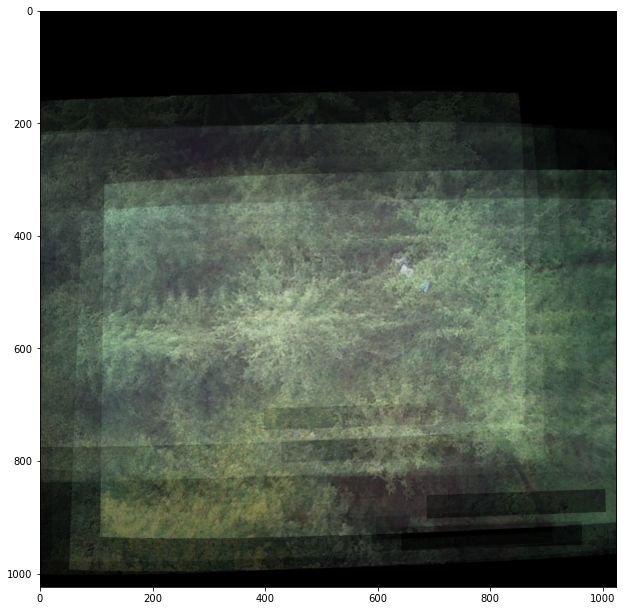

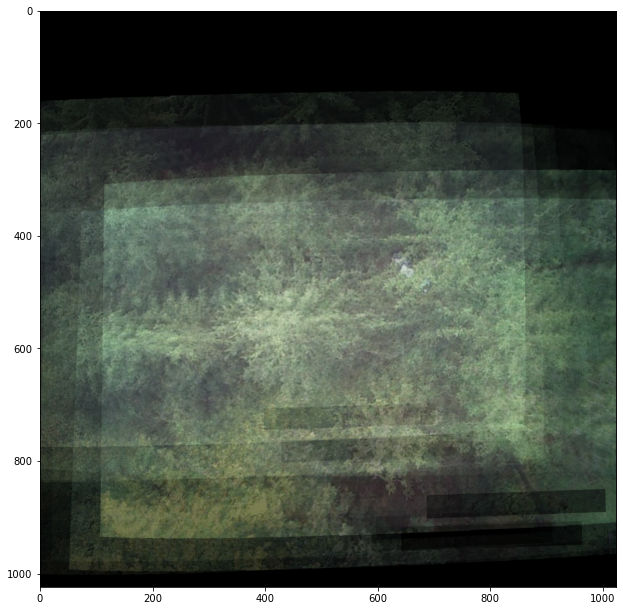

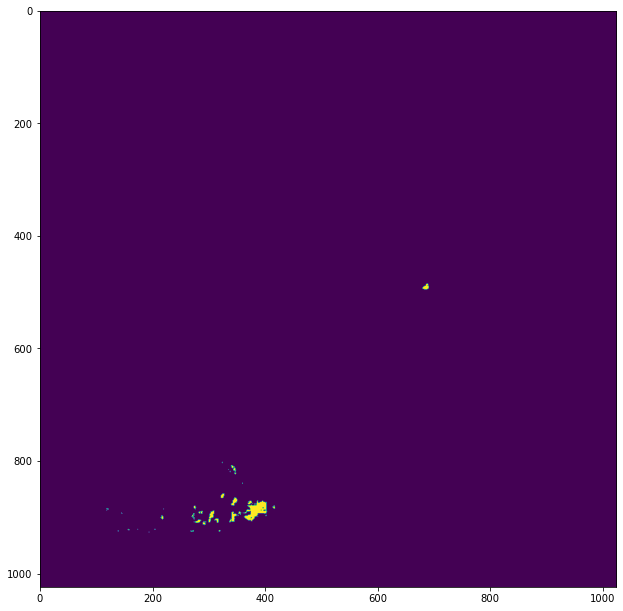

In [88]:
plt.figure(figsize=(10.6, 10.6))
plt.imshow(train_images['train-1-0-0'])
plt.show()
plt.figure(figsize=(10.6, 10.6))
plt.imshow(purified_train_images[0])
plt.show()
plt.figure(figsize=(10.6, 10.6))
plt.imshow(anomaly)
plt.show()

In [46]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from tqdm.notebook import trange,tqdm

class ConvAutoEncoder(nn.Module):
    """ Convolutional auto-encoder. """
    
    def __init__(self, in_channels: int = 1, hid_channels: int = 64, code_channels: int = 256, 
                 kernel_size: int = 9, stride: int = 1, pooling: int = 2, 
                 activation: nn.Module = nn.LeakyReLU()):
        """
        Parameters
        ----------
        in_channels : int
            Number of channels in the inputs.
        hid_channels : int
            Number of channels in the hidden layer(s).
        code_channels : int
            Number of channels in the code.
        kernel_size : int or tuple
            Window size for the convolutions
        stride : int or tuple, optional
            Window strides for the convolutions.
        pooling : int or tuple, optional
            Window size for the average pooling.
        activation : nn.Module, optional
            Activation function for the auto-encoder.
        """
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=1),
            nn.BatchNorm2d(64),
            activation,
            nn.Conv2d(64, 128, kernel_size=5, stride=1),
            nn.BatchNorm2d(128),
            activation,
            nn.Conv2d(128, 256, kernel_size=3, stride=1),
            nn.BatchNorm2d(256),
            activation
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, output_padding=0),
            nn.BatchNorm2d(128),
            activation,
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=1, output_padding=0),
            nn.BatchNorm2d(64),
            activation,
            nn.ConvTranspose2d(64, 3, kernel_size=9, stride=1, output_padding=0),
            nn.BatchNorm2d(3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

cae = ConvAutoEncoder()

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 9, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 5, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of feature maps in discriminator
ndf = 64
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# sanity check
cae = ConvAutoEncoder()


In [47]:
if train:
    width = 256
    height = 256
    dim = (width, height)
    purified_train_images_resized = []
    for i in range(len(purified_train_images)):
        im = cv2.resize(purified_train_images[i], dim, interpolation = cv2.INTER_AREA)
        im = im[np.newaxis]
        im = np.moveaxis(im, [0, 1, 2, 3], [0, 3, 2, 1])
        im = torch.Tensor(im)
        purified_train_images_resized.append(im)

    y = cae(purified_train_images_resized[0])
    cae.encoder(purified_train_images_resized[0]).shape

In [48]:
from torch import optim

def _forward(network: nn.Module, data: DataLoader, metric: callable):
    device = next(network.parameters()).device
    
    for x, y in data:
        x, y = x.to(device), y.to(device)
        logits = network(x)
        res = metric(logits, y)
        yield res


@torch.no_grad()
def evaluate(network: nn.Module, data: DataLoader, metric: callable) -> list:
    network.eval()
    
    results = _forward(network, data, metric)
    return [res.item() for res in results]
    

@torch.enable_grad()
def update(network: nn.Module, data: DataLoader, loss: nn.Module, 
           opt: optim.Optimizer) -> list:
    network.train()
    
    errs = []
    for err in _forward(network, data, loss):
        errs.append(err.item())
        
        opt.zero_grad()
        err.backward()
        opt.step()
    
    return errs


def train_auto_encoder(auto_encoder: nn.Module, loader: DataLoader, 
                       objective: nn.Module, optimiser: optim.Optimizer, 
                       num_epochs: int = 10, vis_every: int = 1):
    """
    Train an auto-encoder for a number of epochs.
    
    Parameters
    ----------
    auto_encoder : nn.Module
        The auto-encoder to train
    loader : DataLoader
        A data loader for iterating over batches of the data.
    objective : nn.Module
        The loss function to optimise during training.
    optimiser : optim.Optimizer
        The optimiser to use for training.
    num_epochs : int, optional
        Number of times to iterate the dataset.
    vis_every : int, optional
        Frequency, during training, of 
        intermediate visualisation of reconstructions.
    """
    # take random batch for visualising reconstructions
    ref_inputs, _ = next(iter(loader))
    
    # evaluate random performance
    errs = evaluate(auto_encoder, loader, objective)
    print(f"Epoch {0: 2d} - avg loss: {sum(errs) / len(errs):.6f}")
    display_result(auto_encoder, ref_inputs)
    
    # train for some epochs
    for epoch in range(1, num_epochs + 1):
        errs = update(auto_encoder, loader, objective, optimiser)
        print(f"Epoch {epoch: 2d} - avg loss: {sum(errs) / len(errs):.6f}")

        if epoch % vis_every == 0:
            display_result(auto_encoder, ref_inputs)
            
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm.notebook import trange,tqdm
import gc
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 1

#dataroot ='data/train'
#dataset = dset.ImageFolder(root=dataroot,
#                           transform=transforms.Compose([
#                               transforms.Resize(image_size),
#                               transforms.CenterCrop(image_size),
#                               transforms.ToTensor(),
#                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                           ]))

if train:
    dataset = purified_train_images_resized
    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=workers)

    learning_rate = 1e-3
    criterion = nn.MSELoss()
    optimiser = torch.optim.Adam(cae.parameters(), lr=learning_rate, weight_decay=1e-5)
    num_epochs = 10
    for epoch in range(num_epochs):
        loss = 0
        for batch_features in dataloader:
            im = torch.squeeze(batch_features, dim=0)
            im = nn.functional.normalize(im)
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimiser.zero_grad()

            # compute reconstructions
            outputs = cae(im)
            # compute training reconstruction loss
            train_loss = criterion(outputs, im)

            # compute accumulated gradients
            train_loss.backward()

            # perform parameter update based on current gradients
            optimiser.step()

            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()

        # compute the epoch training loss
        loss = loss / len(dataloader)

        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, num_epochs, loss))

epoch : 1/10, loss = 0.460501
epoch : 2/10, loss = 0.275659
epoch : 3/10, loss = 0.213842
epoch : 4/10, loss = 0.176525
epoch : 5/10, loss = 0.162063
epoch : 6/10, loss = 0.156862
epoch : 7/10, loss = 0.154226
epoch : 8/10, loss = 0.153097
epoch : 9/10, loss = 0.152344
epoch : 10/10, loss = 0.151651


In [49]:
if train:
    torch.save(cae,'cae.pth')

In [50]:
if train:
    cae = torch.load('cae.pth', map_location='cpu')
    cae.eval();

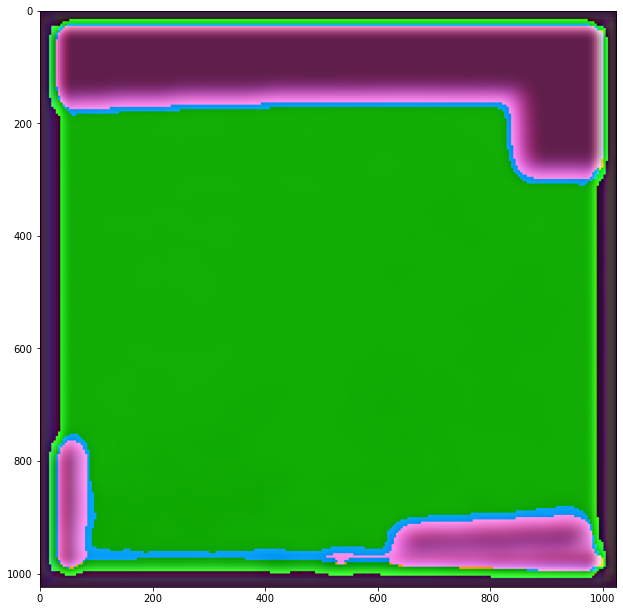

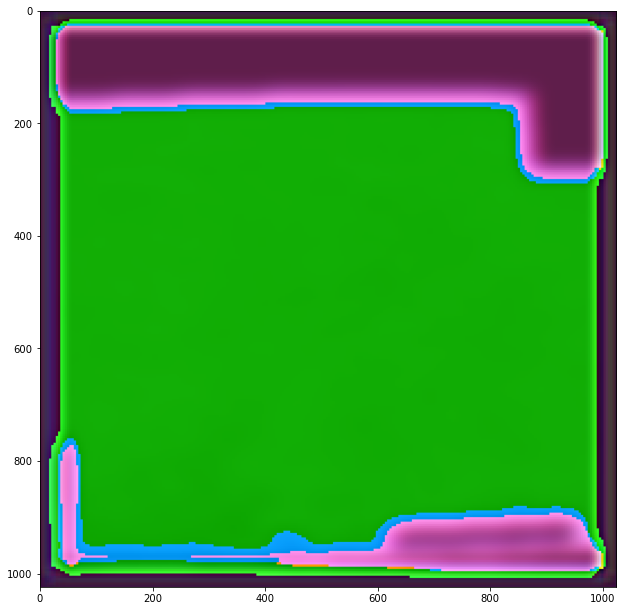

In [52]:
if train:
    width = 256
    height = 256
    dim = (width, height)

    test_image = train_images['train-2-1-0']    
    test_image = cv2.resize(test_image, dim, interpolation = cv2.INTER_AREA)
    test_image = test_image[np.newaxis]
    test_image = np.moveaxis(test_image, [0, 1, 2, 3], [0, 3, 2, 1])
    test_image = torch.Tensor(test_image)

    reconstructed = cae.forward(nn.functional.normalize(purified_train_images_resized[0]))
    reconstructed = torch.squeeze(reconstructed.detach()).T
    width = 1024
    height = 1024
    dim = (width, height)
    reconstructed = cv2.resize(reconstructed.cpu().detach().numpy(), dim, interpolation = cv2.INTER_AREA)

    plt.figure(figsize=(10.6, 10.6))
    plt.imshow((reconstructed * 255).astype(np.uint8))
    plt.show()

    reconstructed = cae.forward(nn.functional.normalize(test_image))
    reconstructed = torch.squeeze(reconstructed.detach()).T
    width = 1024
    height = 1024
    dim = (width, height)
    reconstructed = cv2.resize(reconstructed.cpu().detach().numpy(), dim, interpolation = cv2.INTER_AREA)

    plt.figure(figsize=(10.6, 10.6))
    plt.imshow((reconstructed * 255).astype(np.uint8))
    plt.show()

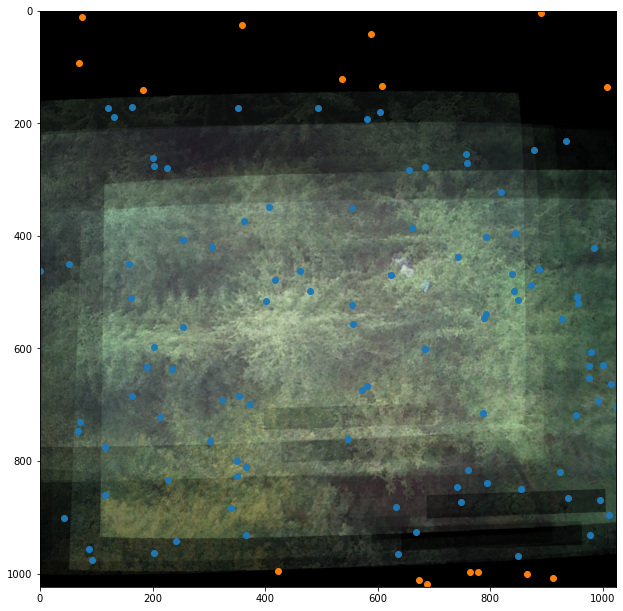

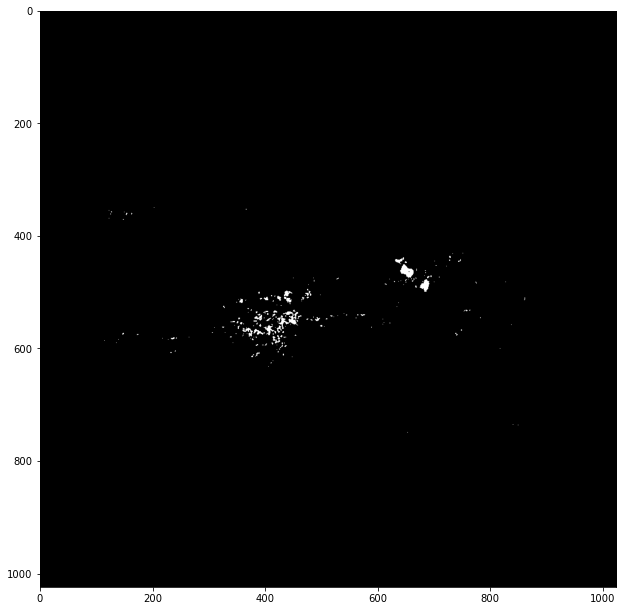

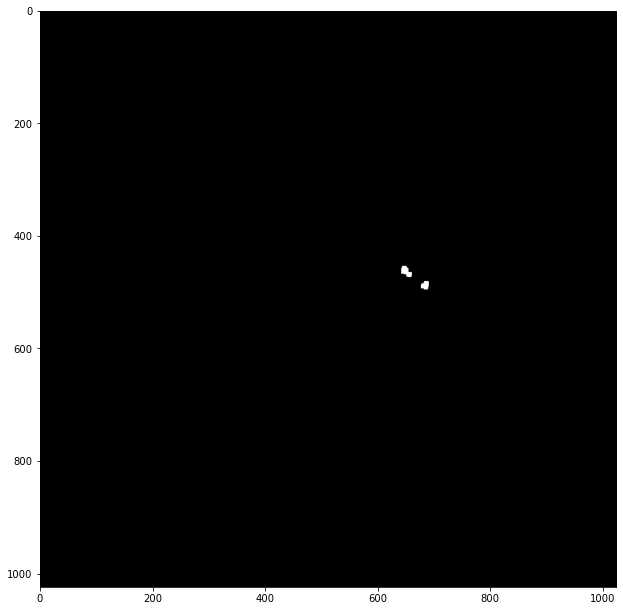

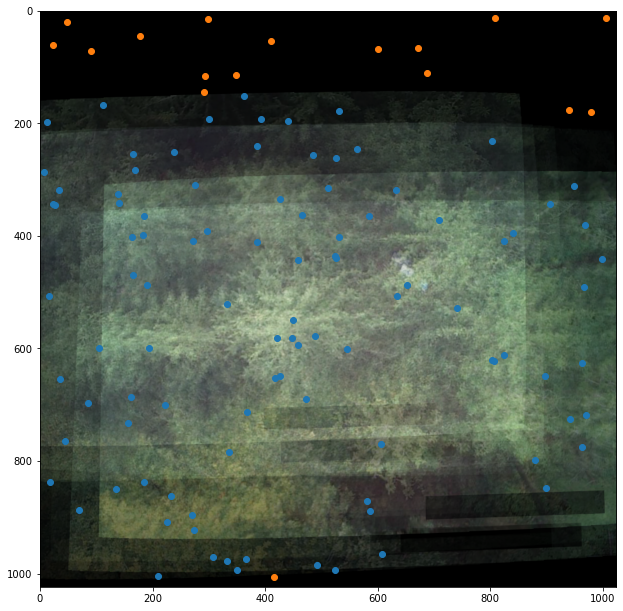

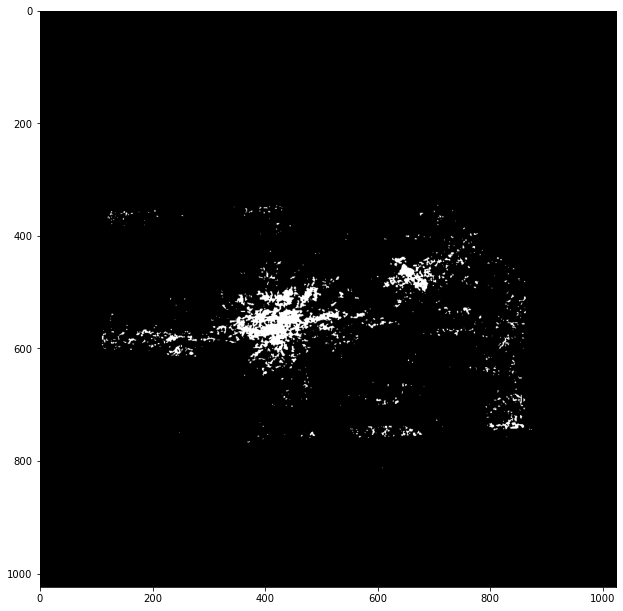

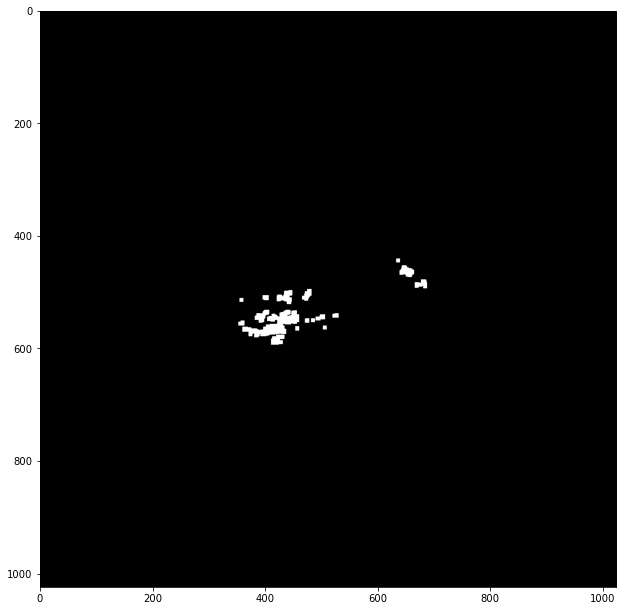

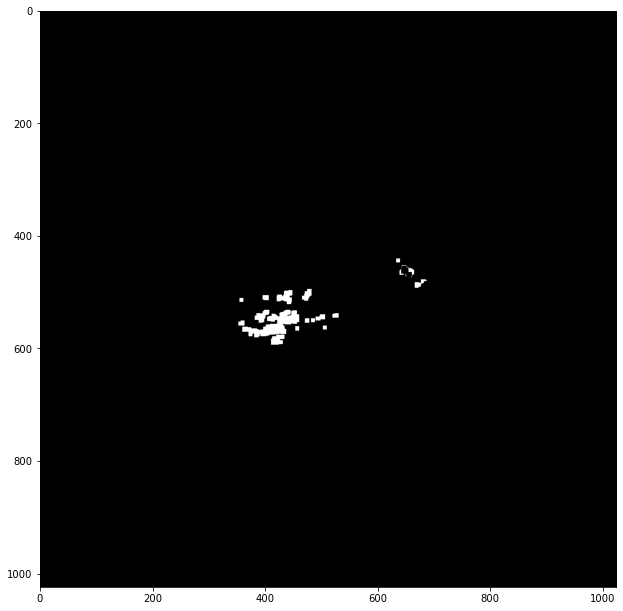

In [105]:
def rCRD(image, r, l): 
    d = image.shape[2]
    n = image.shape[0]*image.shape[1]
    X = image.reshape((d,n)).astype(np.uint8)
    #X = X.reshape((image.shape[0],image.shape[1],image.shape[2]))
    Xr = np.zeros((d,r)).astype(np.uint8)
    A = np.zeros((r,n)).astype(np.uint8)
    Xsampled = np.zeros((image.shape[0], image.shape[1], image.shape[2]))
    
    for i in range(r):
        x = np.random.randint(0, image.shape[0])
        y = np.random.randint(200, image.shape[1]-200)
        #Xsampled[x,y,:] = image[x,y,:]
        Xr[:,i] = image[x,y]
    #Xr = Xsampled.reshape((d,r))
    A = np.linalg.pinv(Xr.T@Xr + l*np.eye(r))@Xr.T@X
        
    delta = np.zeros(n)
    anomaly = np.zeros(n)
    for i in range(n):
        delta[i] = np.linalg.norm(X[:,i]-Xr@A[:,i],2)

    threshold = np.mean(delta)
    for i in range(n):
        if delta[i] > threshold:
            anomaly[i] = 1
        else:
            anomaly[i] = 0
    anomaly = anomaly.reshape((image.shape[0], image.shape[1]))
    delta = delta.reshape((image.shape[0], image.shape[1]))
    return delta

def rCRD_XY(image, r, l, threshold):
    plt.figure(figsize=(10.6, 10.6))
    plt.imshow(image)
    
    image = image.swapaxes(2, 1).swapaxes(0, 1)

    d = image.shape[0]
    n = image.shape[1]*image.shape[2]
    
    X = image.copy()
    Xr = np.zeros([d, r])
    
    pts = []
    f_pts = []
                
    for i in range(r):
        x = np.random.randint(0, image.shape[1])
        y = np.random.randint(0, image.shape[2])
                
        while all(X[:, x, y] == 0) or ((y, x) in pts):
            f_pts.append((y, x))
            x = np.random.randint(0, image.shape[1])
            y = np.random.randint(0, image.shape[2])
        Xr[:, i] = X[:, x, y]
        pts.append((y, x))
        
    plt.scatter(*zip(*pts))
    if len(f_pts) > 0:
        plt.scatter(*zip(*f_pts))
    plt.show()
        
    a = Xr.T @ Xr + l
    unq, count = np.unique(a, axis=0, return_counts=True)
    b = np.linalg.inv(Xr.T @ Xr + l) @ Xr.T
    A = (X.T @ b.T).T
    
    X_est = (A.T @ Xr.T).T
    
    diff = X - X_est
        
    delta = np.linalg.norm(diff, axis=0)
    delta = delta/np.max(delta)
    anomaly = np.where(delta > threshold, 1, 0)
    
    return anomaly

r = 100
t = 0.7

image = train_images['train-1-0-0']
anomaly = rCRD_XY(image, r=r, l=1e-6, threshold=t)

plt.figure(figsize=(10.6, 10.6))
plt.imshow(anomaly, cmap='gray')
plt.show()

kernel = np.ones((7,7),np.uint8)
opened1 = cv2.morphologyEx(anomaly.astype('uint8'), cv2.MORPH_OPEN, kernel)

plt.figure(figsize=(10.6, 10.6))
plt.imshow(opened1, cmap='gray')
plt.show()



image = train_images['train-1-0-2']
anomaly = rCRD_XY(image, r=r, l=1e-6, threshold=t)

plt.figure(figsize=(10.6, 10.6))
plt.imshow(anomaly, cmap='gray')
plt.show()

kernel = np.ones((7,7),np.uint8)
opened2 = cv2.morphologyEx(anomaly.astype('uint8'), cv2.MORPH_OPEN, kernel)

plt.figure(figsize=(10.6, 10.6))
plt.imshow(opened2, cmap='gray')
plt.show()


opened_diff = opened1 - opened2 
plt.figure(figsize=(10.6, 10.6))
plt.imshow(opened_diff, cmap='gray')
plt.show()

In [56]:
print(anomaly.shape)

(1024, 1024)
